In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from resnet18_32x32 import ResNet18_32x32
from torch.utils.data import TensorDataset, DataLoader
import pickle
from sklearn.manifold import TSNE

device = torch.device("cuda" if torch.cuda.is_available() else False)

/root/miniconda3/envs/CGAN/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/root/miniconda3/envs/CGAN/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [72]:
# 加载保存的label_list
with open('../logs/res/mnist/label_tensor.pickle', 'rb') as f:
    label_list = pickle.load(f)

# 加载保存的probs_list
with open('../logs/res/mnist/probs_tensor.pickle', 'rb') as f:
    probs_list = pickle.load(f)

label_tensor = torch.cat(label_list, dim=0)
probs_tensor = torch.cat(probs_list, dim=0)


In [2]:
#参数加载
latent_dim = 10
lr = 0.0002
batch_size = 1
num_epochs = 200
num_classes = 10

class Generator(nn.Module):


    
    def __init__(self, latent_dim, num_classes):
        super(Generator, self).__init__()
        self.label_embed = nn.Embedding(num_classes, latent_dim)
        self.generator = nn.Sequential(
            nn.Linear(latent_dim * 2 , 128),  # 将噪音维度加入生成器输入维度
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, labels, noise):
        gen_input = self.label_embed(labels)
        gen_input_with_noise = torch.cat((gen_input, noise), -1)  # 将噪音和标签嵌入向量连接起来
        class_probs = self.generator(gen_input_with_noise)
        return class_probs

In [22]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 加载类别概率分布数据
with open('../logs/res/cifar/probs_tensor.pickle', 'rb') as f:
    real_probs_list = pickle.load(f)
real_probs_tensor = torch.cat(real_probs_list, dim=0)

# 加载相应的标签
with open('../logs/res/cifar/label_tensor.pickle', 'rb') as f:
    label_list = pickle.load(f)
labels = torch.cat(label_list, dim=0)

# 确定每个类别的样本数
num_classes = len(torch.unique(labels))  # 假设 labels 包含了所有类别的标签
samples_per_class = 100  # 假设您想从每个类别中随机选择500个样本

# 从每个类别中随机选择样本
selected_indices = []

for class_idx in range(num_classes):
    class_indices = [i for i, label in enumerate(labels) if label == class_idx]
    class_indices = random.sample(class_indices, min(samples_per_class, len(class_indices)))
    selected_indices.extend(class_indices)

# 使用随机索引选择样本
selected_samples = real_probs_tensor[selected_indices]
selected_labels = labels[selected_indices]

print(f"选取的样本数: {selected_samples.size(0)}")

选取的样本数: 1000


生成的类别概率分布的数目: 1000


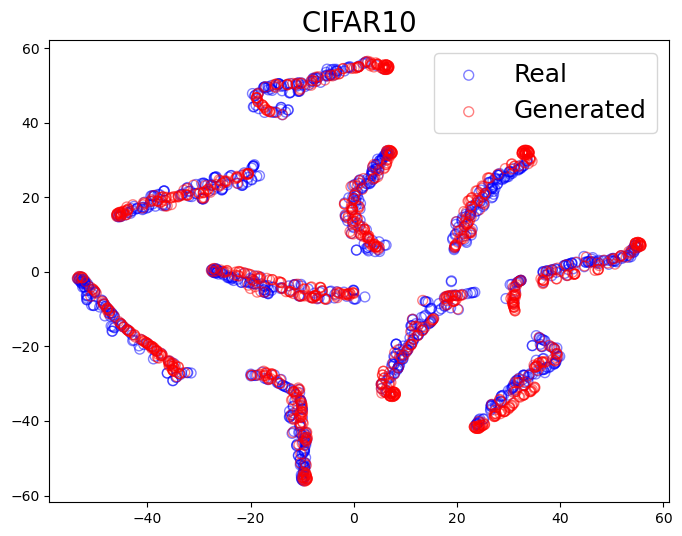

In [24]:
# 生成模拟的类别概率分布数据
# ... 初始化您的生成器模型 ...
# 假设 latent_dim 和 num_classes 已经定义
samples_per_class = 100  # 每个类别生成的样本数量
generated_probs_list = []

# 初始化生成器并加载模型
generator = Generator(latent_dim, num_classes).to(device)
generator.load_state_dict(torch.load('./res/mnist/1/generator130.pth'))
#generator.load_state_dict(torch.load('./output/generator_200+60.pth'))
generator.eval()

with torch.no_grad():
    for class_idx in range(num_classes):
        # 为每个类别生成随机噪声
        noise = torch.randn(samples_per_class, latent_dim).to(device)
        
        # 生成固定类别的标签
        labels = torch.full((samples_per_class,), class_idx, dtype=torch.long).to(device)
        
        # 生成类别概率分布
        class_probs = generator(labels, noise).cpu()
        generated_probs_list.append(class_probs)

# 将所有生成的数据合并
generated_probs = torch.cat(generated_probs_list, dim=0)

# 输出生成的类别概率分布的数目
num_generated_distributions = generated_probs.size(0)
print(f"生成的类别概率分布的数目: {num_generated_distributions}")
# 确保real_probs和generated_probs都在CPU上并都是张量
real_probs = selected_samples.cpu()

# 合并真实和生成的概率分布
combined_data = torch.cat((real_probs, generated_probs), 0).numpy()

# 使用t-SNE进行降维
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(combined_data)

# 可视化
fig, ax = plt.subplots(figsize=(8, 6))  # 调整图像大小
num_real_samples = len(real_probs)

# 真实数据点：空心，蓝色边缘
ax.scatter(tsne_results[:num_real_samples, 0], tsne_results[:num_real_samples, 1], 
           facecolors='none', edgecolors='blue', label='Real', alpha=0.5, s=50)  # 调整点的大小
# 生成的数据点：空心，红色边缘
ax.scatter(tsne_results[num_real_samples:, 0], tsne_results[num_real_samples:, 1], 
           facecolors='none', edgecolors='red', label='Generated', alpha=0.5, s=50)  # 同上
# 调整标签字体大小
ax.legend(fontsize='large')
ax.legend(fontsize=18)  # 调整图例字体大小
ax.set_title(' CIFAR10 ', fontsize=20)  # 添加标题

plt.show()
